In [33]:
!git clone https://github.com/deepsolar/pynlfff.git

fatal: destination path 'pynlfff' already exists and is not an empty directory.


In [34]:
!pip install sunpy[all] pfsspy

from IPython.display import clear_output
clear_output()

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sunpy.net import Fido, attrs as a
from astropy.time import Time
from astropy.io import fits
from astropy import units as u
from datetime import datetime

# Prepare  data

In [36]:
# Downloading an active region

query = Fido.search(
    a.jsoc.Time("2025-11-11T10:04", "2025-11-11T10:04"),
    a.jsoc.Series("hmi.sharp_cea_720s"),
    *[a.jsoc.Segment(seg) for seg in ["Bp","Br","Bt"]],
    a.jsoc.PrimeKey("HARPNUM", 13999),
    a.jsoc.Notify("vivoY75user@gmail.com"))

In [37]:
result = Fido.fetch(query, path="/content/nlfff_gpu/data/raw/")

INFO:sunpy:3 URLs found for download. Full request totaling 3MB


INFO: 3 URLs found for download. Full request totaling 3MB [sunpy.net.jsoc.jsoc]


Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

In [38]:
br_data = fits.open("/content/nlfff_gpu/data/raw/hmi.sharp_cea_720s.13999.20251111_100000_TAI.Bp.fits")[1].data
bp_data = fits.open("/content/nlfff_gpu/data/raw/hmi.sharp_cea_720s.13999.20251111_100000_TAI.Bp.fits")[1].data
bt_data = fits.open("/content/nlfff_gpu/data/raw/hmi.sharp_cea_720s.13999.20251111_100000_TAI.Bp.fits")[1].data

br_data.shape

(441, 1512)

In [39]:
# Crop Br_data to include 400-800 pixels in x and 150-350 in y
y_start = 149  # Corresponds to pixel 150 (0-indexed)
y_end = 400    # Corresponds to pixel 350
x_start = 399  # Corresponds to pixel 400 (0-indexed)
x_end = 700    # Corresponds to pixel 800

Bp_data = bp_data[y_start:y_end, x_start:x_end]
Bt_data = bt_data[y_start:y_end, x_start:x_end]
Br_data = br_data[y_start:y_end, x_start:x_end]

# Update nx, ny based on new cropped data shape if needed for subsequent cells
ny, nx = Br_data.shape
print(f"New cropped size: nx={nx}, ny={ny}")

New cropped size: nx=301, ny=251


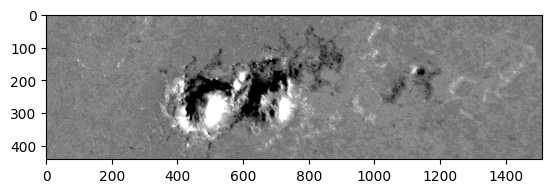

In [40]:
plt.imshow(br_data, cmap = "grey", vmin = -500, vmax = 500)

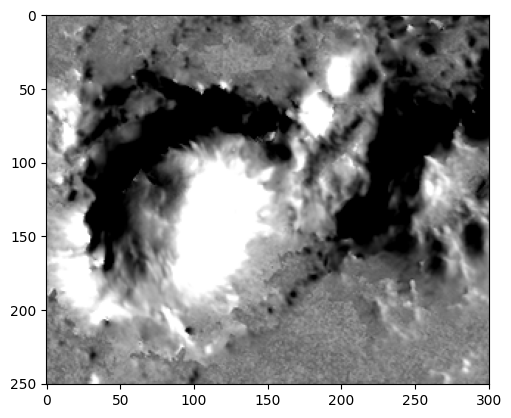

In [41]:
plt.imshow(Br_data, cmap = "grey", vmin = -500, vmax = 500)

# Creating the input files

### boundary.ini

In [42]:
!mkdir "/content/input_files/"

mkdir: cannot create directory ‘/content/input_files/’: File exists


In [43]:
# Set injection speed
nue = 0.001

with open("/content/input_files/boundary.ini", "w") as f:
    f.write(f"nue {nue}\n")
    f.write("Mask B_T/max(B_T)\n")

print(f"boundary.ini written successfully!")

boundary.ini written successfully!


## Level 1

### allboundaries3.dat

In [44]:
br_data = fits.open("/content/nlfff_gpu/data/raw/hmi.sharp_cea_720s.13999.20251111_100000_TAI.Bp.fits")[1].data
bp_data = fits.open("/content/nlfff_gpu/data/raw/hmi.sharp_cea_720s.13999.20251111_100000_TAI.Bp.fits")[1].data
bt_data = fits.open("/content/nlfff_gpu/data/raw/hmi.sharp_cea_720s.13999.20251111_100000_TAI.Bp.fits")[1].data

In [45]:
ny0, nx0 = Br_data.shape
print("Original size:", nx0, ny0)

nx = (nx0 // 4) * 4
ny = (ny0 // 4) * 4
nz = int(((3/8 *(nx + ny)) // 4) * 4)

x0 = (nx0 - nx) // 2
y0 = (ny0 - ny) // 2

Bp_data = Bp_data[y0:y0+ny, x0:x0+nx]
Bt_data = Bt_data[y0:y0+ny, x0:x0+nx]
Br_data = Br_data[y0:y0+ny, x0:x0+nx]

print("Cropped size:", nx, ny)

Original size: 301 251
Cropped size: 300 248


In [46]:
# Moving to cartesian coordinates
b3dx = Bp_data
b3dy = - Bt_data
b3dz = Br_data

# Flattening in fortran order
Bx_f = b3dx.flatten(order='F')
By_f = b3dy.flatten(order='F')
Bz_f = b3dz.flatten(order='F')

In [47]:
# Writing to allboundaries.dat
with open("/content/input_files/allboundaries3.dat", "w") as f:
    for i in range(len(Bx_f)):
        f.write(f"{Bx_f[i]:.6e} {By_f[i]:.6e} {Bz_f[i]:.6e}\n")

print("allboundaries3.dat written successfully")

allboundaries3.dat written successfully


### mask3.dat

In [48]:
B_T = np.sqrt(b3dx**2 + b3dy**2)

# parameter W
W = B_T / np.max(B_T)

# Flattening in fortran order
W_f = W.flatten(order='F')

# Writing to mask3.dat
W_f.tofile("/content/input_files/mask3.dat")
print("mask3.dat written successfully!")

mask3.dat written successfully!


### grid3.ini

In [49]:
nd = 0
with open("/content/input_files/grid3.ini", "w") as f:
    f.write(f"nx {nx}\n")
    f.write(f"ny {ny}\n")
    f.write(f"nz {nz}\n")
    f.write(f"nd {nd}\n")

print("grid3.ini written successfully!")

grid3.ini written successfully!


## Level 2

### allboundaries2.dat

In [50]:
# Downsampling to grid2
nx2 = nx//2
ny2 = ny//2
nz2 = nz//2

b2dx = b3dx.reshape(nx//2, 2, ny//2, 2).mean(axis=(1,3))
b2dy = b3dy.reshape(nx//2, 2, ny//2, 2).mean(axis=(1,3))
b2dz = b3dz.reshape(nx//2, 2, ny//2, 2).mean(axis=(1,3))

# Flattening in fortran order
Bx2_f = b2dx.flatten(order='F')
By2_f = b2dy.flatten(order='F')
Bz2_f = b2dz.flatten(order='F')

In [51]:
# Writing to allboundaries.dat
with open("/content/input_files/allboundaries2.dat", "w") as f:
    for i in range(len(Bx2_f)):
        f.write(f"{Bx2_f[i]:.6e} {By2_f[i]:.6e} {Bz2_f[i]:.6e}\n")

print("allboundaries2.dat written successfully")

allboundaries2.dat written successfully


### mask2.dat

In [52]:
B2_T = np.sqrt(b2dx**2 + b2dy**2)

# parameter W
W2 = B2_T / np.max(B2_T)

# Flattening in fortran order
W2_f = W2.flatten(order='F')

# Writing to mask3.dat
W2_f.tofile("/content/input_files/mask2.dat")
print("mask2.dat written successfully!")

mask2.dat written successfully!


### grid2.ini

In [53]:
nd = 0
with open("/content/input_files/grid2.ini", "w") as f:
    f.write(f"nx {nx2}\n")
    f.write(f"ny {ny2}\n")
    f.write(f"nz {nz2}\n")
    f.write(f"nd {nd}\n")

print("grid2.ini written successfully!")

grid2.ini written successfully!


## Level 3

### allboundaries1.dat

In [54]:
# Downsample again to grid 1
nx1 = nx2 // 2
ny1 = ny2 // 2
nz1 = nz2 // 2

b1dx = b2dx.reshape(nx1, 2, ny1, 2).mean(axis=(1, 3))
b1dy = b2dy.reshape(nx1, 2, ny1, 2).mean(axis=(1, 3))
b1dz = b2dz.reshape(nx1, 2, ny1, 2).mean(axis=(1, 3))

# Flatten for fortran order
Bx1_f = b1dx.flatten(order='F')
By1_f = b1dy.flatten(order='F')
Bz1_f = b1dz.flatten(order='F')

In [55]:
# Writing to allboundaries.dat
with open("/content/input_files/allboundaries1.dat", "w") as f:
    for i in range(len(Bx1_f)):
        f.write(f"{Bx1_f[i]:.6e} {By1_f[i]:.6e} {Bz1_f[i]:.6e}\n")

print("allboundaries1.dat written successfully")

allboundaries1.dat written successfully


### mask1.dat

In [56]:
B1_T = np.sqrt(b1dx**2 + b1dy**2)

# parameter W
W1 = B1_T / np.max(B1_T)

# Flattening in fortran order
W1_f = W1.flatten(order='F')

# Writing to mask1.dat
W1_f.tofile("/content/input_files/mask1.dat")
print("mask1.dat written successfully!")

mask1.dat written successfully!


### grid1.ini

In [57]:
nd = 0
with open("/content/input_files/grid1.ini", "w") as f:
    f.write(f"nx {nx1}\n")
    f.write(f"ny {ny1}\n")
    f.write(f"nz {nz1}\n")
    f.write(f"nd {nd}\n")

print("grid1.ini written successfully!")

grid1.ini written successfully!


# Using the solver

In [ ]:
import os

# Change to the wiegelmann_nlfff directory
original_dir = os.getcwd()
os.chdir('/content/pynlfff/pynlfff/cnlfff/wiegelmann_nlfff/')

# Compile the code for cpu.parallel.amd (x86_64)
!make -f Makefile.cpu.p.amd

# Change back to the original directory
os.chdir(original_dir)

# Now, try to run the multigrid.cpu.sh script, assuming it will use the newly compiled binaries
# The script multigrid.cpu.sh is also in the same directory
# We will need to adjust the path to the binaries inside multigrid.cpu.sh if it hardcodes the 'arm' path.
!bash /content/pynlfff/pynlfff/cnlfff/wiegelmann_nlfff/multigrid.cpu.sh /content/input_files 123

make: Nothing to be done for 'all'.
BASE INFORMATION:
File name:        linff run log
App file name:    /content/pynlfff/pynlfff/cnlfff/wiegelmann_nlfff/multigrid.cpu.sh
Compute platform: 
Byte Order:                              Little Endian
Linux 17674b4e0bf9 6.6.105+ #1 SMP Thu Oct  2 10:42:05 UTC 2025 x86_64 x86_64 x86_64 GNU/Linux
-----------------------------------------------
RUN LOG:
RUN grid:
123
start run date:
Tue Jan 13 02:20:39 PM UTC 2026
workspace:
/content/input_files


 Compiled by OpenMP 


 argv[0]: 	 /content/pynlfff/pynlfff/cnlfff/wiegelmann_nlfff/relax4
 argv[1]: 	 23
 argv[2]: 	 0
 calcb= 23 	 maxit= 0

 Ls=1.000000 	 mu0= 0.000001
 nx= 75, ny=62 , nz= 51 


 Size of double: 8
 nxnynz * Size of double: 1897200
 nxnynz * Size of float: 948600
 Computing Potential field 

 nx= 75, ny=62 , nz= 51 

 Vectormagnetogram loaded
 Only Bz is used for potential field 

 percent finished = 50.666667
 percent finished = 0.000000
 percent finished = 1.333333
 percent finishe